In [1]:
import sqlite3

# Connect to the database
conn = sqlite3.connect('OS_data_experiment_results.db')

# Create a cursor object to interact with the database
cursor = conn.cursor()

# Delete the row with the specified hyperparameter_hash
hyperparameter_hash_to_delete = '5258e7efa228a51660e4aa2d9efebffa69557883b795ae7b4e8b4b612fb34b4f'
cursor.execute("DELETE FROM experiment_results WHERE hyperparameter_hash = ?;", (hyperparameter_hash_to_delete,))

# Commit the changes
conn.commit()

# Commit the changes
conn.commit()
# Execute a query on the table (replace 'experiment_results' with your table name)
cursor.execute("SELECT * FROM experiment_results WHERE which_split='Test';")

# Fetch the column names
column_names = [description[0] for description in cursor.description]
print("Column names:", column_names)

# Fetch and display rows
rows = cursor.fetchall()
for row in rows:
    print(row)

Column names: ['preprocessing_hash', 'hyperparameter_hash', 'method', 'which_split', 'preprocessing_hyperparameters', 'method_hyperparameters', 'metric']
('ef19085e70a2b043dd00e10361154f3ec54122c056f0a5236099c900ff889eff', '26ae617ef9faa8d53f68070a0006972ba4f44de104e228e08db6dff8172086a9', 'Sequential-DoubleThresholdBS+SingleThresholdSPC', 'Test', '{"label_transform_dict": {"0": 0, "1": 1, "4": 5, "5": 5}, "lin_fit_quantiles": {"py/tuple": [10, 90]}, "remove_uncertain": false, "subsequent_nr": 5}', '{"anomaly_detection_method": {"py/type": "src.methods.SingleThresholdStatisticalProcessControl"}, "cutoffs_per_method": [[{"py/tuple": [288, 4032]}, {"py/tuple": [4032, Infinity]}], [{"py/tuple": [0, 24]}, {"py/tuple": [24, 288]}]], "method_hyperparameter_dict_list": [{"beta": 0.008, "jump": 10, "min_size": 200, "model": "l1", "move_avg": 1, "penalty": "L1", "quantiles": {"py/tuple": [15, 85]}, "reference_point": "mean", "scaling": true, "score_function_kwargs": {"beta": 1.5}}, {"move_avg":

In [2]:
def load_batch(data_folder):
    X_path = os.path.join(data_folder, "X")
    y_path = os.path.join(data_folder, "y")

    X_files = sorted(os.listdir(X_path))
    y_files = sorted(os.listdir(y_path))

    if not X_files == y_files:
        raise RuntimeError("Not all training files are present in both the X and y folders.")

    file_names = X_files

    X_dfs, y_dfs = [], []
    for file in file_names:
        X_dfs.append(pd.read_csv(os.path.join(X_path, file)))
        y_dfs.append(pd.read_csv(os.path.join(y_path, file)))
        
    return X_dfs, y_dfs, file_names

In [3]:
station=9
from src.methods import SingleThresholdARIMA
import os
import pandas as pd
from src.plot_functions import plot_predictions
import jsonpickle
import pickle
from src.plot_functions import plot_single_prediction 

home = "/data/tijmen/base_roel_model/StormPhase2/data"

dataset = "OS_data" #alternatively: route_data
data_folder = os.path.join(home, dataset)
result_folder = os.path.join(home+"/results", dataset)
intermediates_folder = os.path.join(home+ "/intermediates", dataset)
model_folder = os.path.join(home + "/saved_models", dataset)

In [4]:


score_folder = os.path.join(result_folder, "scores")
predictions_folder = os.path.join(result_folder, "predictions")
metric_folder = os.path.join(result_folder, "metrics")

preprocessed_X_folder = os.path.join(intermediates_folder, "preprocessed_data_csvs")
label_filter_folder = os.path.join(intermediates_folder, "label_filters_per_cutoff_csvs")

test_csvs_path = intermediates_folder + '/preprocessed_data_csvs/Test'
preprocessing_hash ='ef19085e70a2b043dd00e10361154f3ec54122c056f0a5236099c900ff889eff'
test_csvs_path = os.path.join(test_csvs_path, preprocessing_hash)
X_dfs, y_dfs, dfs_files = load_batch(test_csvs_path)


station number:  9


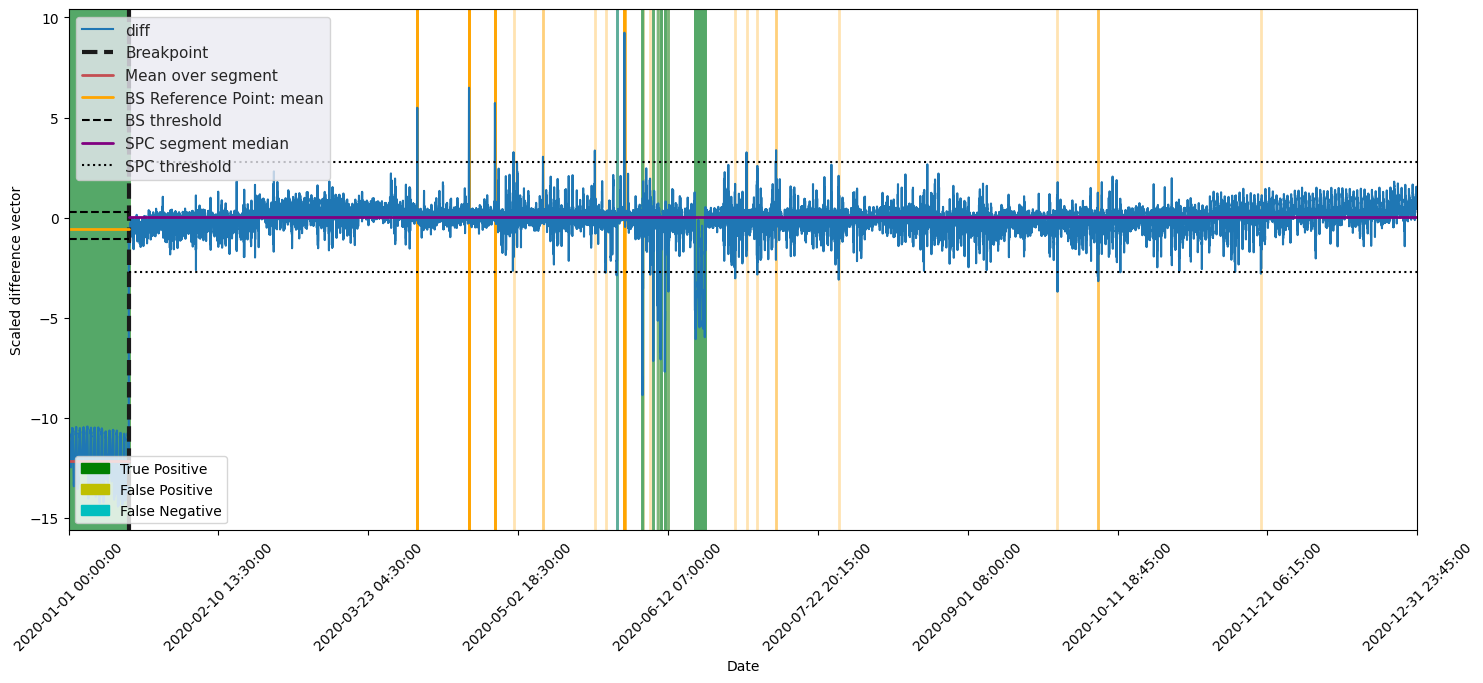

In [5]:
from src.methods import SequentialEnsemble

method = 'Sequential-DoubleThresholdBS+SingleThresholdSPC'

preds_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/predictions/Test', preprocessing_hash, method)
scores_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/scores/Test', preprocessing_hash, method)


best_model_entry = cursor.execute("""
SELECT e.* 
FROM experiment_results e 
WHERE e.metric = (
    SELECT MAX(metric)
    FROM experiment_results
    WHERE method = (?) AND which_split = (?)
) AND e.method = (?)
""", (method, "Test", method))

(preprocessing_hash, hyperparameter_hash, _, _, preprocessing_hyperparameter_string_pickle, hyperparameter_string_pickle, validation_metric) = next(best_model_entry)

model_hyperparameters = jsonpickle.decode(hyperparameter_string_pickle, keys=True)
model = SequentialEnsemble(model_folder, preprocessing_hash, **model_hyperparameters)
model.load_model()

preds_path = os.path.join(preds_path, hyperparameter_hash, 'predictions.pickle')
with open(preds_path, 'rb') as handle:
        predictions = pickle.load(handle)
        
scores_path = os.path.join(scores_path, hyperparameter_hash, 'scores.pickle')
with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)
        

plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model, which_stations = [station], scores=scores)
   

station number:  9
9.900749871336586


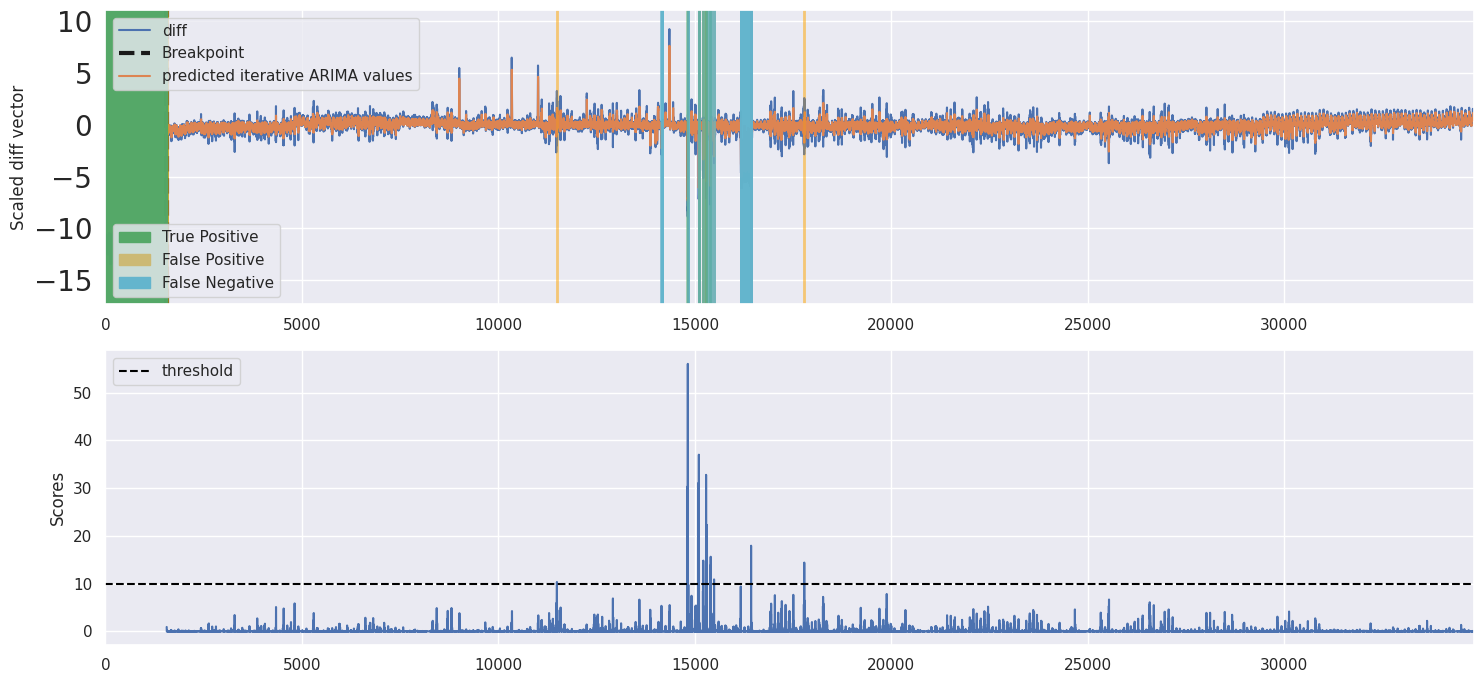

In [6]:
from src.methods import SequentialEnsemble
import numpy as np

method = 'Sequential-DoubleThresholdBS+SingleThresholdSARIMAX'

preds_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/predictions/Test', preprocessing_hash, method)
scores_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/scores/Test', preprocessing_hash, method)


best_model_entry = cursor.execute("""
SELECT e.* 
FROM experiment_results e 
WHERE e.metric = (
    SELECT MAX(metric)
    FROM experiment_results
    WHERE method = (?) AND which_split = (?)
) AND e.method = (?)
""", (method, "Test", method))

(preprocessing_hash, hyperparameter_hash, _, _, preprocessing_hyperparameter_string_pickle, hyperparameter_string_pickle, validation_metric) = next(best_model_entry)

model_hyperparameters = jsonpickle.decode(hyperparameter_string_pickle, keys=True)
model = SequentialEnsemble(model_folder, preprocessing_hash, **model_hyperparameters)
model.load_model()

preds_path = os.path.join(preds_path, hyperparameter_hash, 'predictions.pickle')
with open(preds_path, 'rb') as handle:
        predictions = pickle.load(handle)
values_path = os.path.join(scores_path, hyperparameter_hash, 'values.pickle')
with open(values_path, 'rb') as handle:
        values = pickle.load(handle)       
scores_path = os.path.join(scores_path, hyperparameter_hash, 'scores.pickle')
with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)

plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model,  which_stations = [station], scores=scores, values=values)
   

9.900749871336586


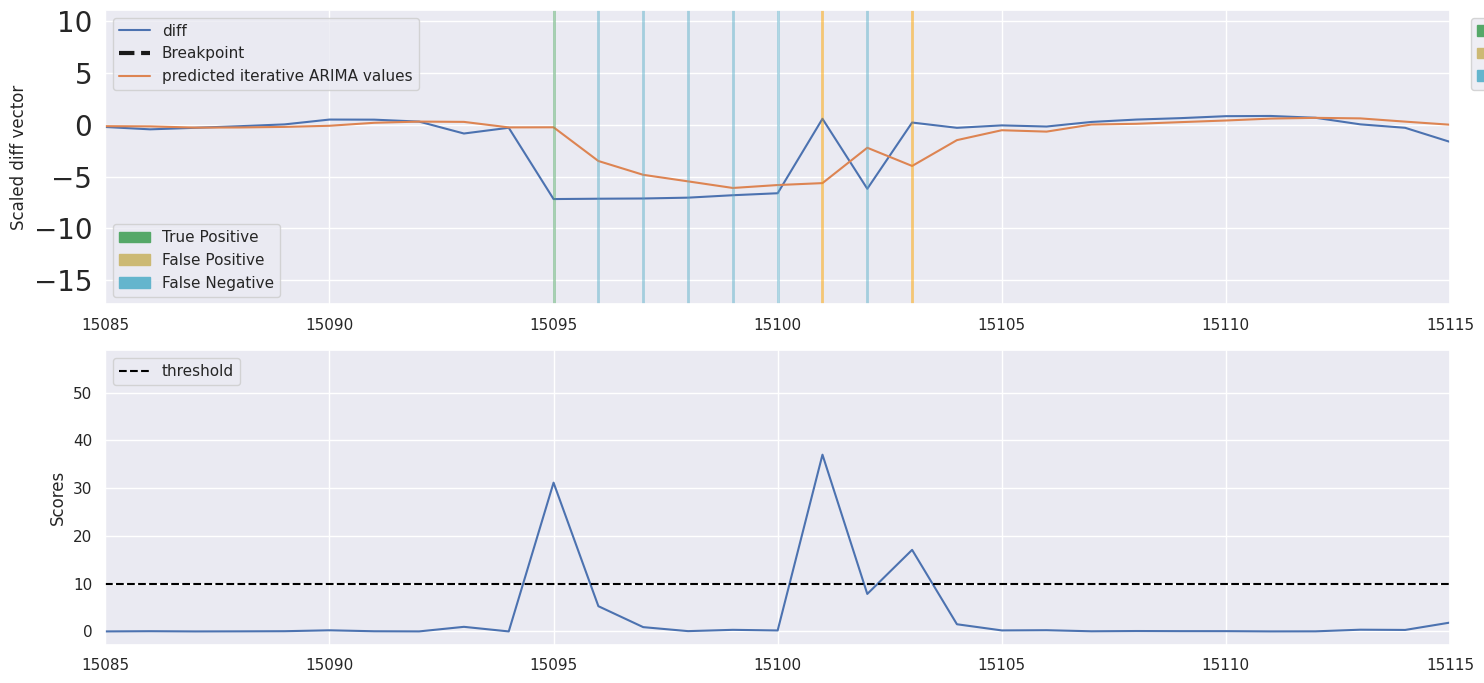

In [7]:

plot_single_prediction(X_dfs[station], y_dfs[station], predictions[station], dfs_files, model, scores=scores[station],values=values[station], interval=(15085,15115))
  

station number:  9
32.789307261948125


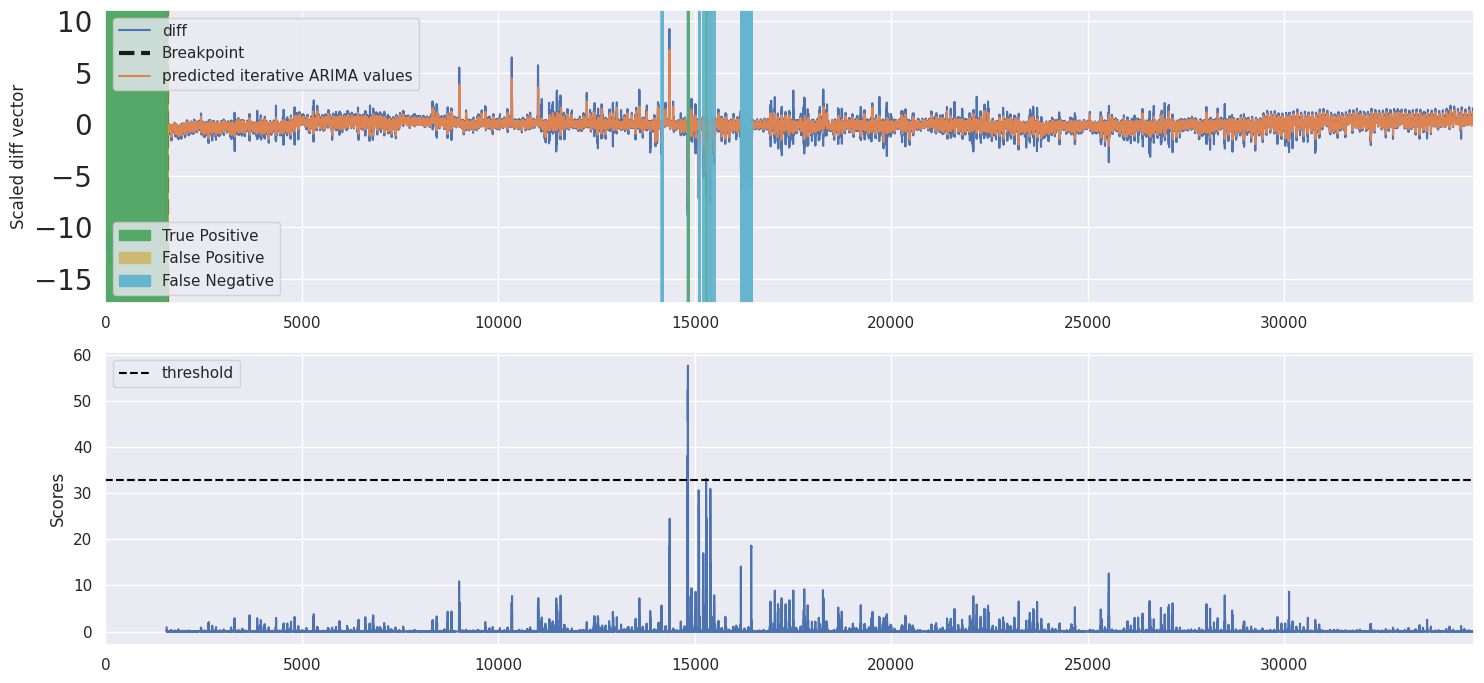

In [8]:
from src.methods import SequentialEnsemble
import numpy as np

method = 'Sequential-DoubleThresholdBS+SingleThresholdARIMA'

preds_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/predictions/Test', preprocessing_hash, method)
scores_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/scores/Test', preprocessing_hash, method)


best_model_entry = cursor.execute("""
SELECT e.* 
FROM experiment_results e 
WHERE e.metric = (
    SELECT MAX(metric)
    FROM experiment_results
    WHERE method = (?) AND which_split = (?)
) AND e.method = (?)
""", (method, "Test", method))

(preprocessing_hash, hyperparameter_hash, _, _, preprocessing_hyperparameter_string_pickle, hyperparameter_string_pickle, validation_metric) = next(best_model_entry)

model_hyperparameters = jsonpickle.decode(hyperparameter_string_pickle, keys=True)
model = SequentialEnsemble(model_folder, preprocessing_hash, **model_hyperparameters)
model.load_model()

preds_path = os.path.join(preds_path, hyperparameter_hash, 'predictions.pickle')
with open(preds_path, 'rb') as handle:
        predictions = pickle.load(handle)
values_path = os.path.join(scores_path, hyperparameter_hash, 'values.pickle')
with open(values_path, 'rb') as handle:
        values = pickle.load(handle)       
scores_path = os.path.join(scores_path, hyperparameter_hash, 'scores.pickle')
with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)
station=9
plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model,  which_stations = [station], scores=scores, values=values)
   

32.789307261948125


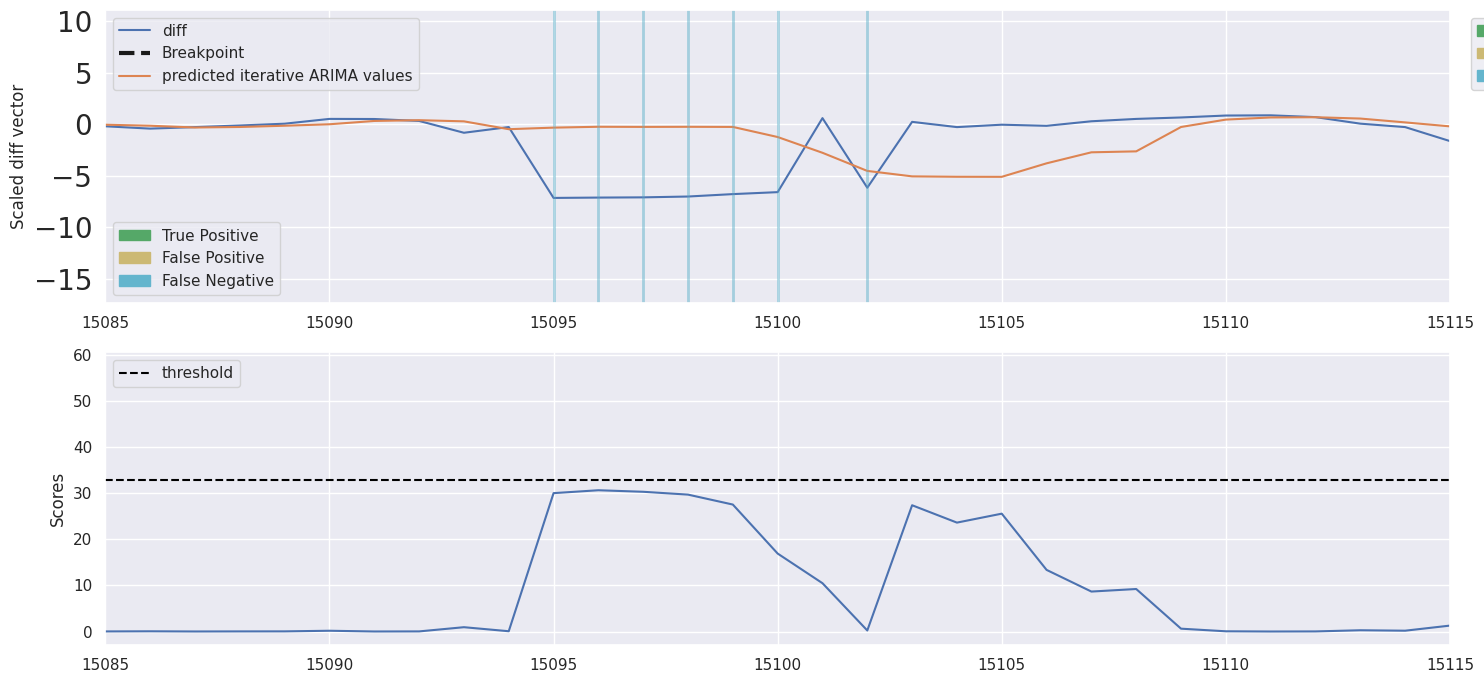

In [9]:

plot_single_prediction(X_dfs[station], y_dfs[station], predictions[station], dfs_files, model, scores=scores[station],values=values[station], interval=(15085,15115))
  

station number:  9
9.821828479098684


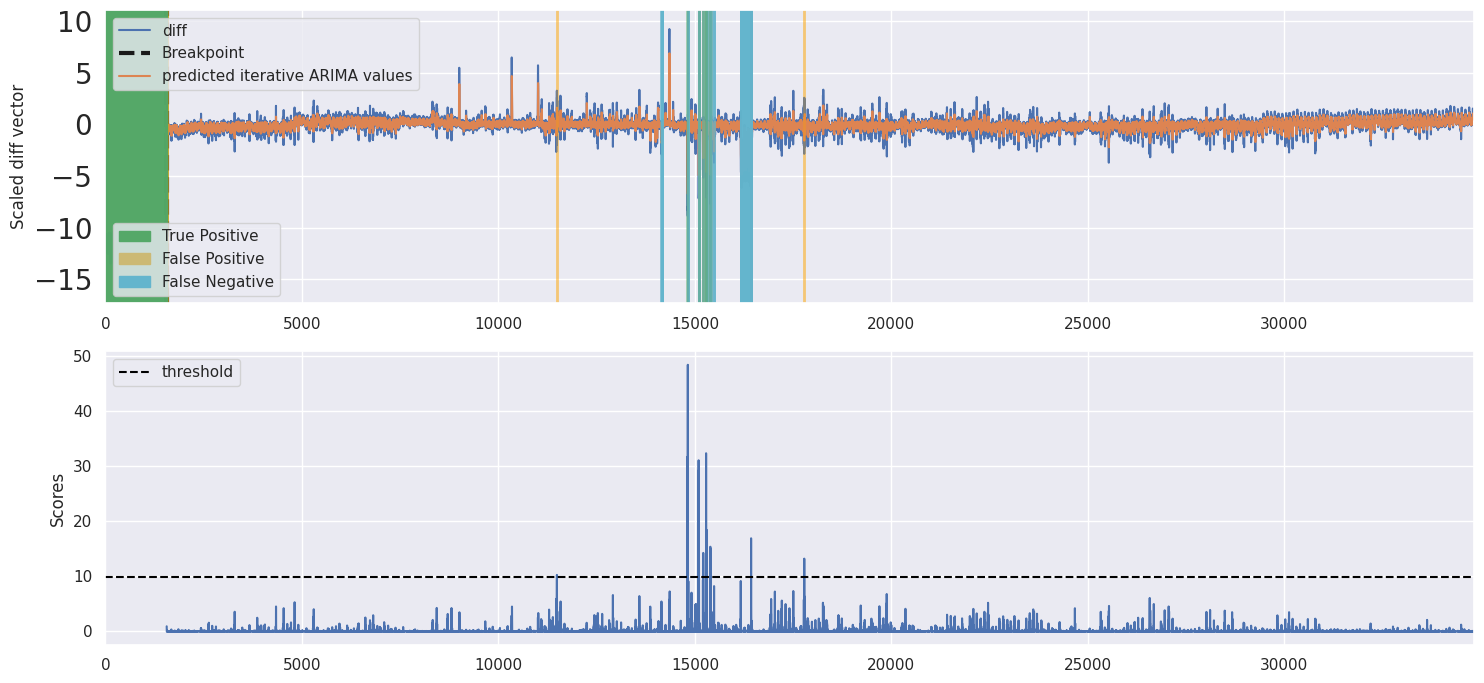

In [10]:
from src.methods import SequentialEnsemble
import numpy as np

method = 'Sequential-DoubleThresholdBS+SingleThresholdSingleARIMA'

preds_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/predictions/Test', preprocessing_hash, method)
scores_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/scores/Test', preprocessing_hash, method)


best_model_entry = cursor.execute("""
SELECT e.* 
FROM experiment_results e 
WHERE e.metric = (
    SELECT MAX(metric)
    FROM experiment_results
    WHERE method = (?) AND which_split = (?)
) AND e.method = (?)
""", (method, "Test", method))

(preprocessing_hash, hyperparameter_hash, _, _, preprocessing_hyperparameter_string_pickle, hyperparameter_string_pickle, validation_metric) = next(best_model_entry)

model_hyperparameters = jsonpickle.decode(hyperparameter_string_pickle, keys=True)
model = SequentialEnsemble(model_folder, preprocessing_hash, **model_hyperparameters)
model.load_model()

preds_path = os.path.join(preds_path, hyperparameter_hash, 'predictions.pickle')
with open(preds_path, 'rb') as handle:
        predictions = pickle.load(handle)
values_path = os.path.join(scores_path, hyperparameter_hash, 'values.pickle')
with open(values_path, 'rb') as handle:
        values = pickle.load(handle)       
scores_path = os.path.join(scores_path, hyperparameter_hash, 'scores.pickle')
with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)
station=9
plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model,  which_stations = [station], scores=scores, values=values)
   

9.821828479098684


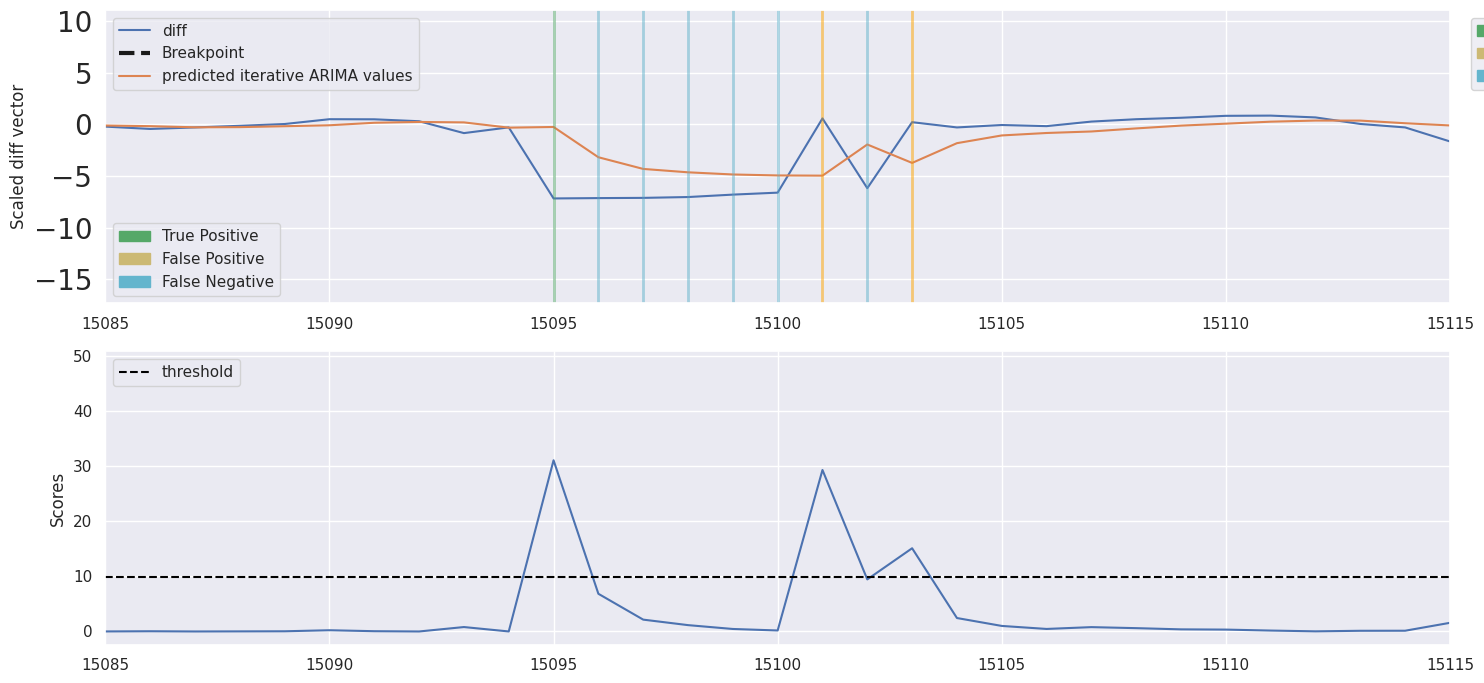

In [11]:

plot_single_prediction(X_dfs[station], y_dfs[station], predictions[station], dfs_files, model, scores=scores[station],values=values[station], interval=(15085,15115))
  

station number:  7
9.821828479098684


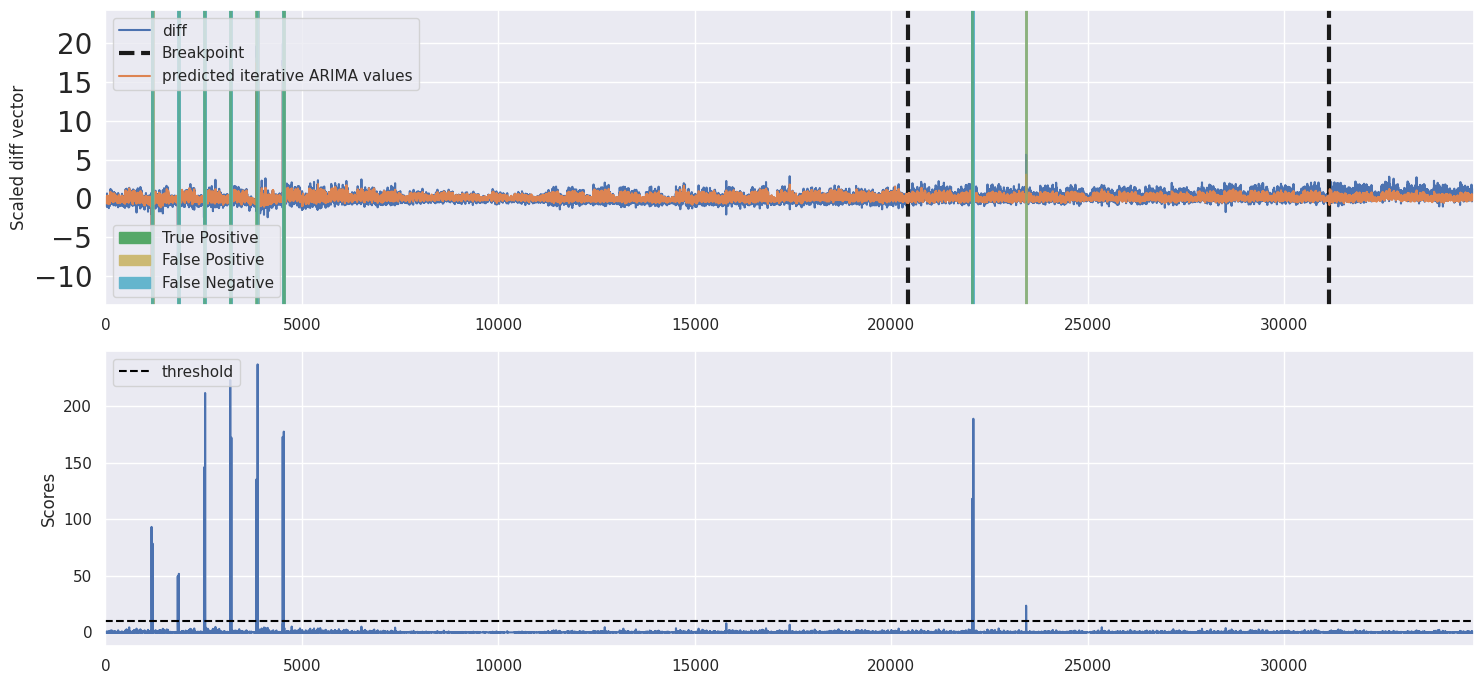

In [12]:
plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model,  which_stations = [7], scores=scores, values=values)

station number:  9
32.789307261948125


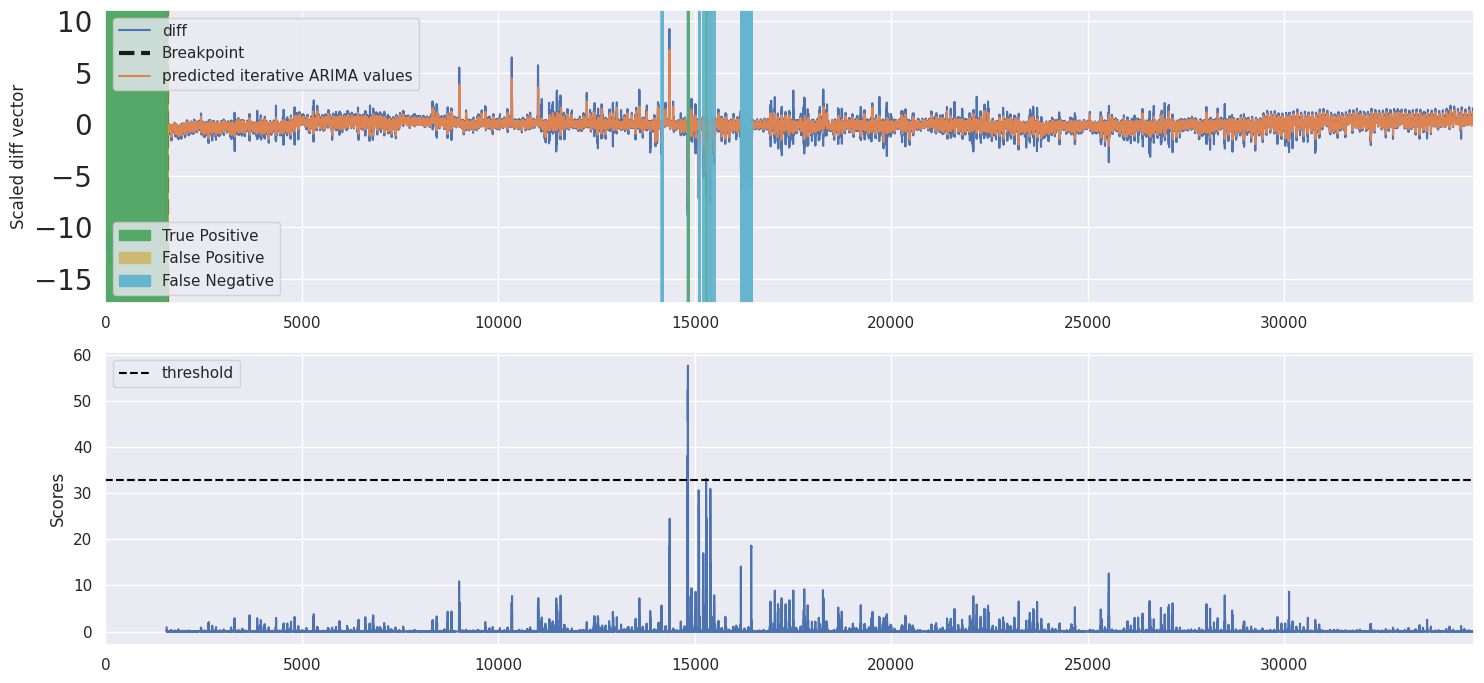

In [13]:
from src.methods import SequentialEnsemble
import numpy as np

method = 'Sequential-DoubleThresholdBS+SingleThresholdARIMA'

preds_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/predictions/Test', preprocessing_hash, method)
scores_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/scores/Test', preprocessing_hash, method)


best_model_entry = cursor.execute("""
SELECT e.* 
FROM experiment_results e 
WHERE e.metric = (
    SELECT MAX(metric)
    FROM experiment_results
    WHERE method = (?) AND which_split = (?)
) AND e.method = (?)
""", (method, "Validation", method))

(preprocessing_hash, hyperparameter_hash, _, _, preprocessing_hyperparameter_string_pickle, hyperparameter_string_pickle, validation_metric) = next(best_model_entry)

model_hyperparameters = jsonpickle.decode(hyperparameter_string_pickle, keys=True)
model = SequentialEnsemble(model_folder, preprocessing_hash, **model_hyperparameters)
model.load_model()

preds_path = os.path.join(preds_path, hyperparameter_hash, 'predictions.pickle')
with open(preds_path, 'rb') as handle:
        predictions = pickle.load(handle)
values_path = os.path.join(scores_path, hyperparameter_hash, 'values.pickle')
with open(values_path, 'rb') as handle:
        values = pickle.load(handle)       
scores_path = os.path.join(scores_path, hyperparameter_hash, 'scores.pickle')
with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)

plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model,  which_stations = [station], scores=scores, values=values)
 

32.789307261948125


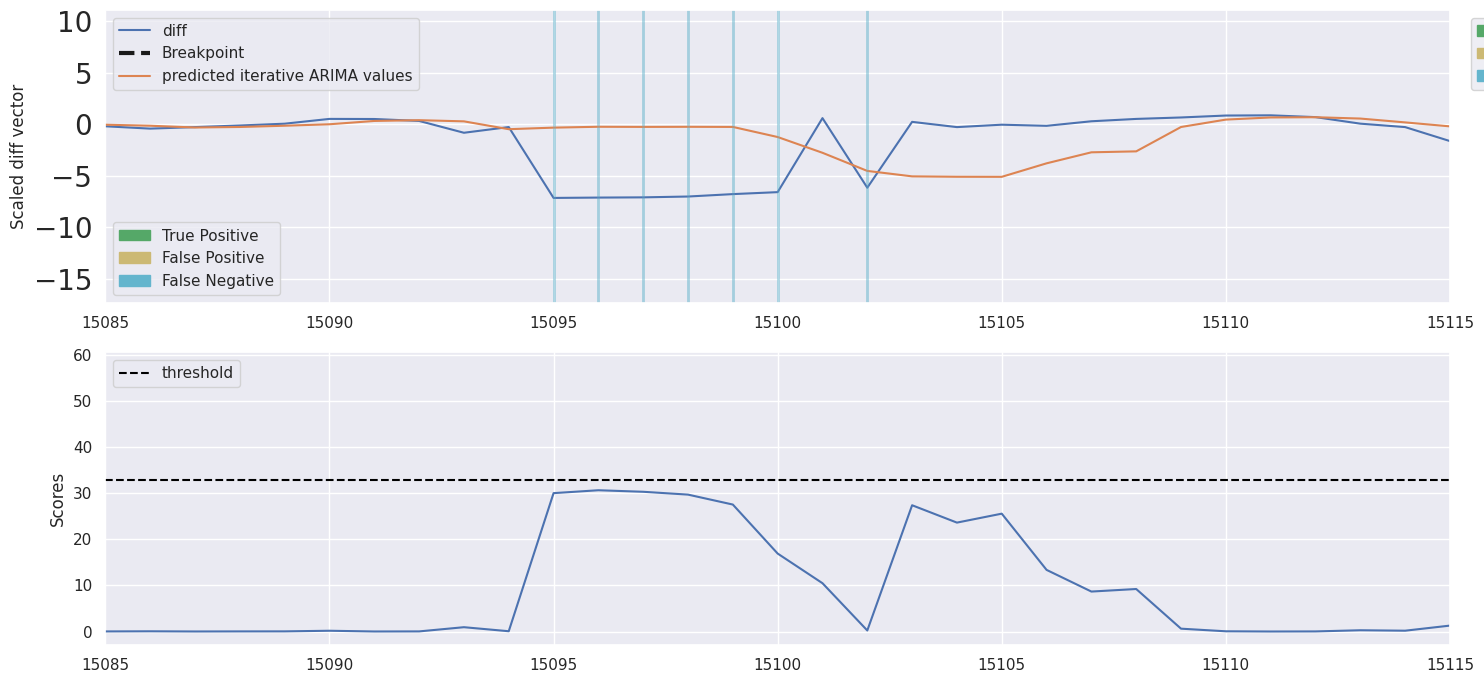

In [14]:

plot_single_prediction(X_dfs[station], y_dfs[station], predictions[station], dfs_files, model, scores=scores[station],values=values[station], interval=(15085,15115))
  

station number:  12
32.789307261948125


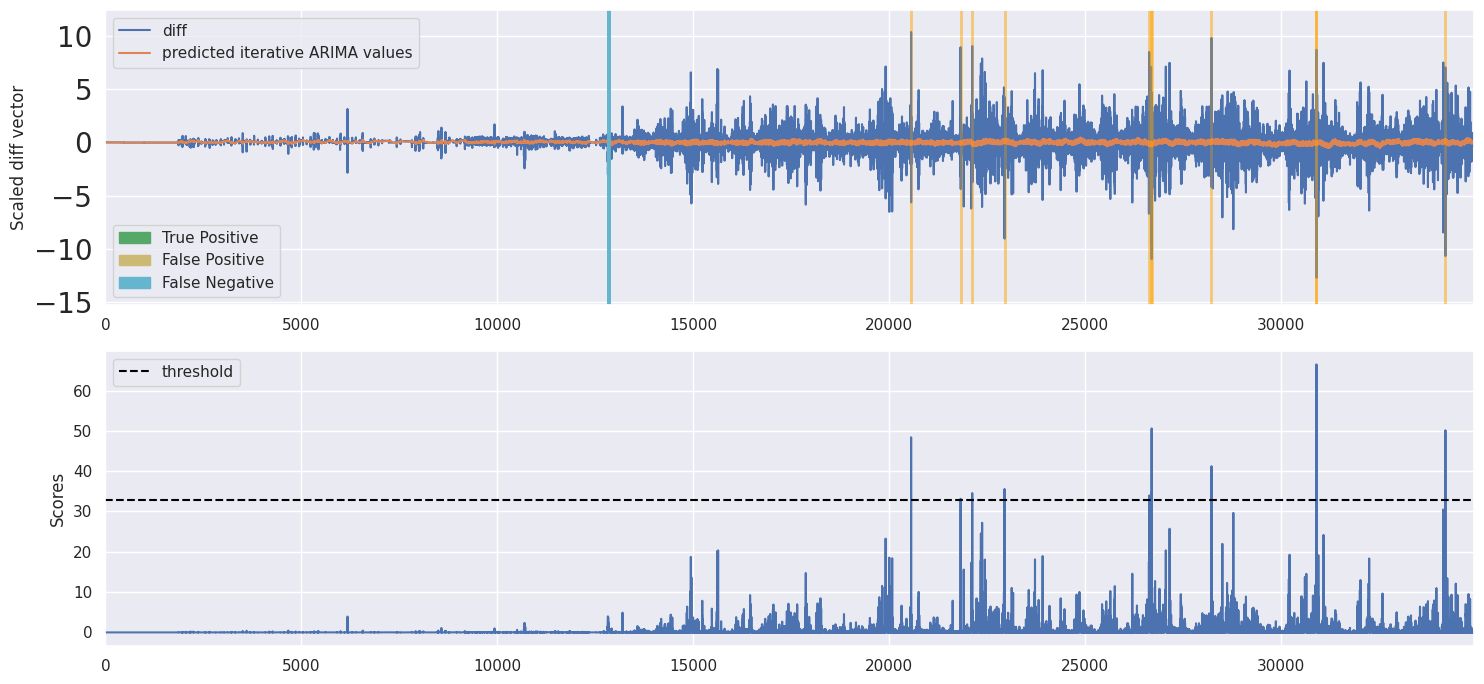

In [15]:
from src.methods import SequentialEnsemble
import numpy as np

method = 'Sequential-DoubleThresholdBS+SingleThresholdARIMA'

preds_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/predictions/Test', preprocessing_hash, method)
scores_path = os.path.join('/data/tijmen/base_roel_model/StormPhase2/data/results/OS_data/scores/Test', preprocessing_hash, method)

best_model_entry = cursor.execute("""
SELECT e.* 
FROM experiment_results e 
WHERE e.metric = (
    SELECT MAX(metric)
    FROM experiment_results
    WHERE method = (?) AND which_split = (?)
) AND e.method = (?)
""", (method, "Validation", method))

(preprocessing_hash, hyperparameter_hash, _, _, preprocessing_hyperparameter_string_pickle, hyperparameter_string_pickle, validation_metric) = next(best_model_entry)

model_hyperparameters = jsonpickle.decode(hyperparameter_string_pickle, keys=True)
model = SequentialEnsemble(model_folder, preprocessing_hash, **model_hyperparameters)
model.load_model()

preds_path = os.path.join(preds_path, hyperparameter_hash, 'predictions.pickle')
with open(preds_path, 'rb') as handle:
        predictions = pickle.load(handle)
values_path = os.path.join(scores_path, hyperparameter_hash, 'values.pickle')
with open(values_path, 'rb') as handle:
        values = pickle.load(handle)       
scores_path = os.path.join(scores_path, hyperparameter_hash, 'scores.pickle')
with open(scores_path, 'rb') as handle:
        scores = pickle.load(handle)

plot_predictions(X_dfs, y_dfs, predictions, dfs_files, model,  which_stations = [12], scores=scores, values=values)
 